# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
import random

np.random.seed(777)
tf.random.set_seed(777)
random.seed(777)

2025-05-08 22:08:01.629555: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
df = pd.read_csv('Data/App Reviews-SingleLabel-Multiclass.csv')

print(f"Dataset shape: {df.shape}")
print("\nSample data:")
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())

print("\nBasic statistics:")
print(df.describe(include='all'))

Dataset shape: (2900, 2)

Sample data:
                                              review                Label
0                                 يبيله تصليحات كثير           bug_report
1                  ماتحملت ابدددددا ونا دفعت فلوس 🤔😕               rating
2  اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...  improvement_request
3      ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت               rating
4                                تبين م لي ي تم ل يب               others

Missing values:
review    0
Label     0
dtype: int64

Basic statistics:
              review   Label
count           2900    2900
unique          2892       4
top     اكثر من رائع  rating
freq               3    1298


# Analysis

🔹 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review       2900 non-null   object
 1   Label        2900 non-null   object
 2   text_length  2900 non-null   int64 
 3   word_count   2900 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 90.8+ KB
None

🔹 Class Distribution:
Label
rating                 1298
bug_report              756
improvement_request     442
others                  404
Name: count, dtype: int64


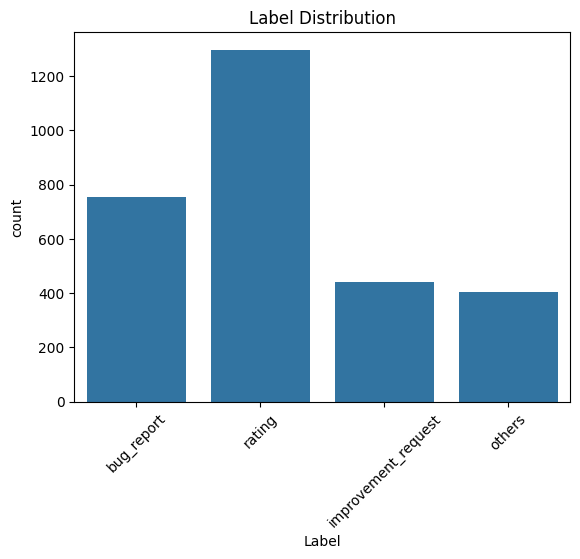


🔹 Review Length (characters):
count    2900.000000
mean       74.374828
std        87.071689
min        10.000000
25%        34.000000
50%        52.000000
75%        85.000000
max      3023.000000
Name: text_length, dtype: float64


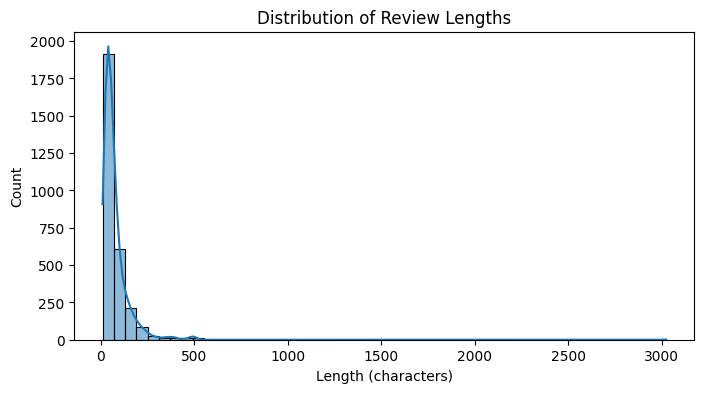


🔹 Word Count per Review:
count    2900.000000
mean       13.551724
std        15.870392
min         3.000000
25%         6.000000
50%        10.000000
75%        16.000000
max       576.000000
Name: word_count, dtype: float64


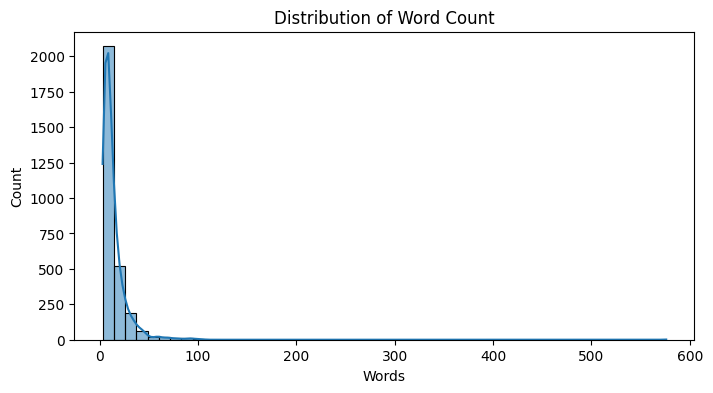

In [ ]:
# Show basic info
print("🔹 Basic Info:")
print(df.info())

# Class distribution
print("\n🔹 Class Distribution:")
print(df['Label'].value_counts())
sns.countplot(data=df, x='Label')
plt.title('Label Distribution')
plt.xticks(rotation=45)
plt.show()



# Review length statistics
df['text_length'] = df['review'].astype(str).apply(len)
print("\n🔹 Review Length (characters):")
print(df['text_length'].describe())

# Plot distribution of review lengths
plt.figure(figsize=(8, 4))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.show()

# Word count statistics
df['word_count'] = df['review'].astype(str).apply(lambda x: len(x.split()))
print("\n🔹 Word Count per Review:")
print(df['word_count'].describe())

# Plot word count
plt.figure(figsize=(8, 4))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()

# Preproccessing

In [ ]:
def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['processed_text'] = df['review'].apply(preprocess_text)

print("Original vs Processed Text Examples:")
for i in range(3):
    print(f"Original: {df['review'].iloc[i]}")
    print(f"Processed: {df['processed_text'].iloc[i]}")
    print()

Original vs Processed Text Examples:
Original: يبيله تصليحات كثير
Processed: يبيله تصليحات كثير

Original: ماتحملت ابدددددا ونا دفعت فلوس 🤔😕
Processed: ماتحملت ابدددددا ونا دفعت فلوس

Original: اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوضاً عن تفضيل الحلقات فقط
وشكراً
Processed: اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوضا عن تفضيل الحلقات فقط وشكرا



# Data split

In [ ]:

label_mapping = {'bug_report': 0, 'improvement_request': 1, 'rating': 2, 'others': 3}
df['label_encoded'] = df['Label'].map(label_mapping)

X = df['processed_text'].values
y = df['label_encoded'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15/0.8, random_state=777, stratify=y_train_val
)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

print("\nLabel distribution in train set:")
print(pd.Series(y_train).value_counts().sort_index())

print("\nLabel distribution in validation set:")
print(pd.Series(y_val).value_counts().sort_index())

print("\nLabel distribution in test set:")
print(pd.Series(y_test).value_counts().sort_index())

Train set size: 1885
Validation set size: 435
Test set size: 580

Label distribution in train set:
0    492
1    288
2    843
3    262
Name: count, dtype: int64

Label distribution in validation set:
0    113
1     66
2    195
3     61
Name: count, dtype: int64

Label distribution in test set:
0    151
1     88
2    260
3     81
Name: count, dtype: int64


# Text Tokenization and Sequence Preparation

In [ ]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = min(MAX_NUM_WORDS, len(word_index) + 1)
print(f"Found {len(word_index)} unique tokens. Using vocab size of {vocab_size}")

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

print(f"Training data shape: {X_train_pad.shape}")
print(f"Validation data shape: {X_val_pad.shape}")
print(f"Test data shape: {X_test_pad.shape}")

Found 8693 unique tokens. Using vocab size of 8694
Training data shape: (1885, 100)
Validation data shape: (435, 100)
Test data shape: (580, 100)


# LSTM model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Convert labels to categorical (one-hot encoded)
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=4)
y_val_cat = to_categorical(y_val, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

# Build LSTM Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 output classes
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Analysis:
This simple LSTM model serves as a baseline.
Improvement: Try Bidirectional LSTM or GRU for better feature extraction.

# Train the Model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train_cat,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_pad, y_val_cat),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.4171 - loss: 1.3166 - val_accuracy: 0.4483 - val_loss: 1.2627
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4995 - loss: 1.1650 - val_accuracy: 0.6138 - val_loss: 1.0232
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.7179 - loss: 0.6862 - val_accuracy: 0.6230 - val_loss: 1.1023
Epoch 4/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8386 - loss: 0.3578 - val_accuracy: 0.5954 - val_loss: 1.2073
Epoch 5/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9308 - loss: 0.2117 - val_accuracy: 0.6391 - val_loss: 1.4810


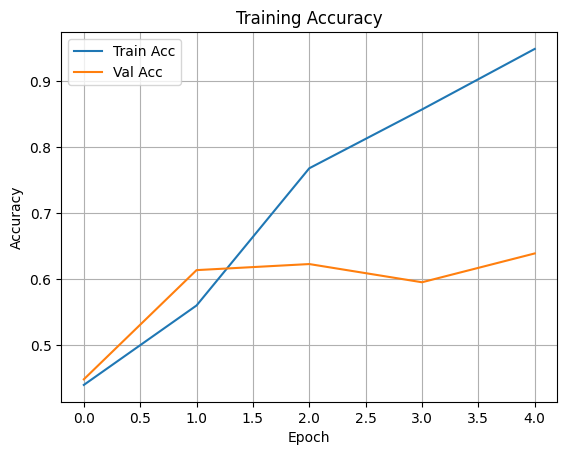

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Analysis:
Training curve behavior can help detect overfitting.
Improvement: If val accuracy plateaus early, apply early stopping or dropout tuning.

# Evaluate the Model

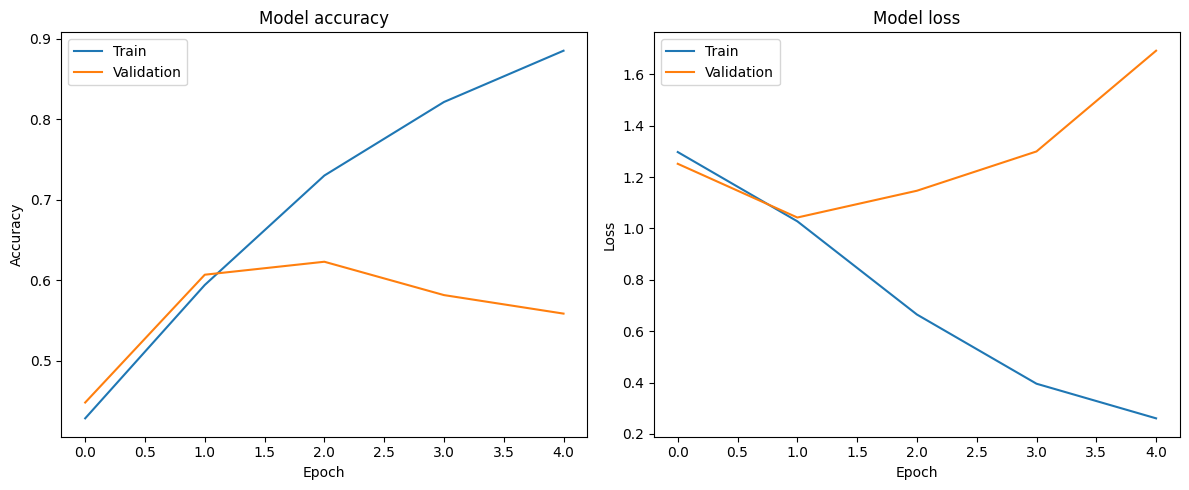

Test accuracy: 0.6069
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step

Classification Report:
                     precision    recall  f1-score   support

         bug_report       0.57      0.71      0.63       151
improvement_request       0.00      0.00      0.00        88
             rating       0.64      0.90      0.75       260
             others       0.41      0.14      0.20        81

           accuracy                           0.61       580
          macro avg       0.40      0.44      0.40       580
       weighted avg       0.49      0.61      0.53       580



/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

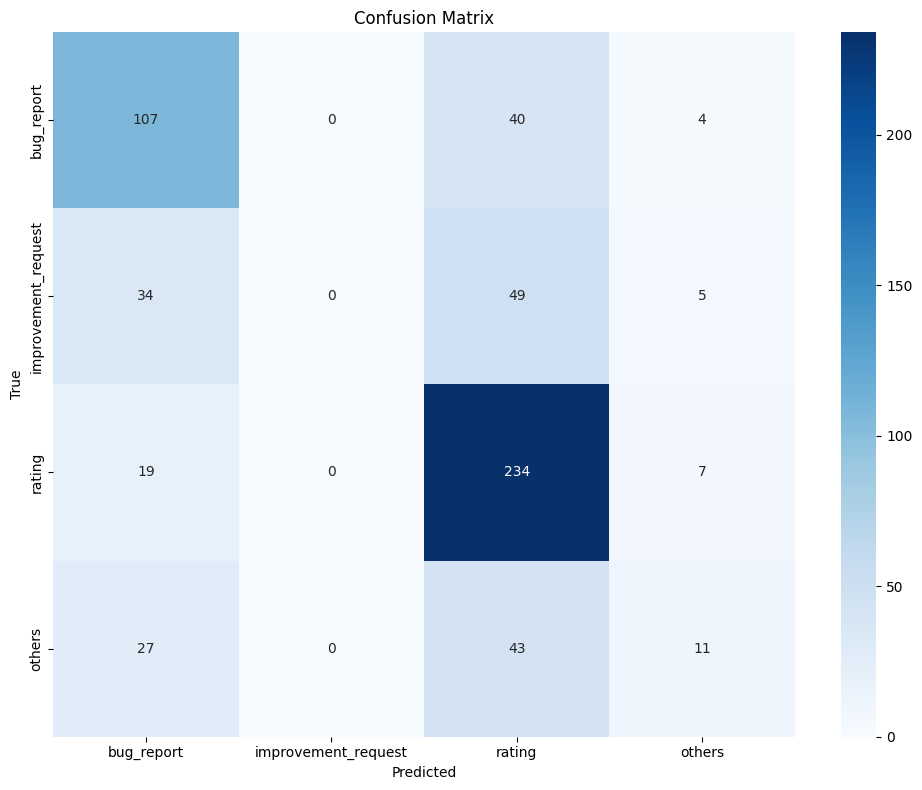

In [ ]:
test_loss, test_acc = model.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

## Analysis:
Baseline accuracy reveals model’s capacity to generalize.
Improvement: Check confusion matrix and add class weighting if imbalance exists.

# Train embedding from scratch

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=4)
y_val_cat = to_categorical(y_val, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

# Define model
model = Sequential([
    Embedding(input_dim=vocab_size,         # vocabulary size (from tokenizer)
              output_dim=128,               # size of each word vector
              input_length=MAX_SEQUENCE_LENGTH),  # fixed sequence length
    LSTM(128, return_sequences=False),      # core LSTM layer
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')          # 4 output classes
])

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Summary
model.summary()

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train_cat,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_pad, y_val_cat),
    callbacks=[early_stop],
    verbose=1
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.4351 - loss: 1.3118 - val_accuracy: 0.4529 - val_loss: 1.2373
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5438 - loss: 1.1321 - val_accuracy: 0.6253 - val_loss: 1.0235
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7281 - loss: 0.6794 - val_accuracy: 0.6092 - val_loss: 1.0782
Epoch 4/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8778 - loss: 0.3400 - val_accuracy: 0.6092 - val_loss: 1.2759
Epoch 5/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9457 - loss: 0.1821 - val_accuracy: 0.6069 - val_loss: 1.4554


## Analysis:
Training embeddings from scratch captures domain-specific context.
Improvement: Consider increasing embedding dimensions or using subword tokenization.

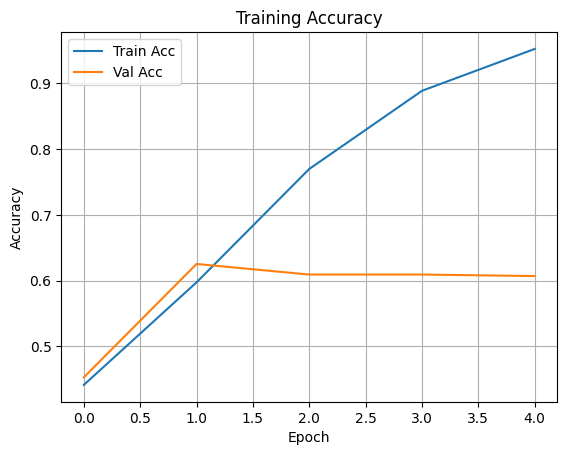

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 59.48%


# use pre-trained embedding

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm

# Load MARBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")
model = AutoModel.from_pretrained("UBC-NLP/MARBERT")
model.eval()  # set model to evaluation mode


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

## Analysis:

Accuracy boost shows benefit from pretrained semantic knowledge.
Improvement: Use domain-adapted embeddings like AraVec or FastText-Arabic.

In [ ]:
def get_sentence_embedding(texts, tokenizer, model, max_length=128):
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Encoding"):
            encoded = tokenizer(text, truncation=True, padding='max_length', max_length=max_length,
                                return_tensors='pt')
            output = model(**encoded)
            cls_embedding = output.last_hidden_state[:, 0, :]  # [CLS] token embedding
            embeddings.append(cls_embedding.squeeze().numpy())
    return np.array(embeddings)


In [ ]:
X_train_emb = get_sentence_embedding(X_train, tokenizer, model)
X_val_emb = get_sentence_embedding(X_val, tokenizer, model)
X_test_emb = get_sentence_embedding(X_test, tokenizer, model)


Encoding: 100%|██████████| 580/580 [00:51<00:00, 11.24it/s]


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=4)
y_val_cat = to_categorical(y_val, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape

model_lstm = Sequential([
    Reshape((1, 768), input_shape=(768,)),  # reshape to (batch, time_steps=1, features=768)
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()


/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,780 (1.78 MB)

 Trainable params: 467,780 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_lstm.fit(
    X_train_emb, y_train_cat,
    validation_data=(X_val_emb, y_val_cat),
    epochs=10,
    batch_size=32
)


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4475 - loss: 1.2386 - val_accuracy: 0.6253 - val_loss: 0.9064
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6551 - loss: 0.8909 - val_accuracy: 0.7057 - val_loss: 0.7500
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7177 - loss: 0.7375 - val_accuracy: 0.7379 - val_loss: 0.6924
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7280 - loss: 0.6687 - val_accuracy: 0.7310 - val_loss: 0.7074
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7660 - loss: 0.6275 - val_accuracy: 0.7287 - val_loss: 0.6979
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7661 - loss: 0.5987 - val_accuracy: 0.7379 - val_loss: 0.6713
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7603 - loss: 0.6122 - val_accuracy: 0.7540 - val_loss: 0.6544
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7824 - loss: 0.5707 - val_accuracy: 0.7586 - val_loss

In [ ]:
test_loss, test_acc = model_lstm.evaluate(X_test_emb, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7419 - loss: 0.7213 
Test Accuracy: 0.7414


# Final Evaluation:

## Analysis:
Final report validates model ranking (e.g. BERT > pretrained > scratch).
Improvement: Consider ensemble of top models to boost generalization.